In [522]:
import datetime
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr

In [561]:
def ends(df, n):
    """Show both head and tail of a pandas series or dataframe.
    
    Parameters
    -----------
    n: int
        # of rows to display in head and tail, respectively (i.e. the total
        # of rows displayed will be 2*n).
    """
    return pd.concat([df.head(n), df.tail(n)], axis=0)

In [524]:
def top_cats(df, col, cats=None, val=None):
    """Filter a df to only include the most common categories.
    
    Parameters
    -----------
    cats: int
        Optional - # of categories to include (i.e. top 5 most common
        categories).
    val: int
        Optional - Value count threshold to include (i.e. all categories that
        occur at least 10 times).
    """
    if cats is not None:
        top = df[col].value_counts(ascending=False).head(cats).index
        return df[df[col].isin(top)]
    if val is not None:
        return df.groupby(col).filter(lambda x: len(x) >= val)

In [560]:
def wc_normalize(df, col, gb, robust=False):
    """Normalize stats by weightclass.
    
    Parameters
    -----------
    df: pd.DataFrame
        Dataframe containing column to normalize.
    col: str
        Name of column to normalize.
    gb: pd.DataFrame
        Pandas groupby object.
    robust: bool
        If False, use mean and standard deviation to scale. If True, use 
        median and IQR.
    """
    center = 'median'
    spread = 'iqr'
    if not robust:
        center = 'mean'
        spread = 'std'
    meds = gb.loc[:][col][center]
    iqrs = gb.loc[:][col][spread]
    return (df[col] - df.wc.map(meds)) / df.wc.map(iqrs)

In [526]:
iqr_ = partial(iqr, nan_policy='omit')

## Load Data

In [527]:
pd.DataFrame.ends = ends
pd.Series.ends = ends

In [528]:
df = pd.read_csv('merged.csv', parse_dates=['dob', 'birth_date'])
print(df.shape)
df.head(3)

(2589, 29)


,d,l,nc,w,association,birth_date,class,country,dob,fname,...,slpm,stance,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,weight1,weight2
0,0,4,NaN,13,The Kennel Fight Club,1989-09-22,Light Heavyweight,United States,1989-09-22,Corey,...,4.37,Orthodox,0.46,0.59,0.0,0.50,4.96,0.83,205.0,205.0
1,0,4,NaN,18,Jackson-Wink MMA,1984-09-20,Lightweight,United States,1984-09-20,Quinn,...,1.48,Orthodox,0.28,0.51,0.0,0.20,1.36,0.33,155.0,155.0
2,0,3,NaN,20,Wand Fight Team,1969-10-31,Bantamweight,United States,1969-10-31,Jason,...,0.51,Orthodox,0.40,0.43,0.0,0.12,1.91,0.50,135.0,135.0


In [529]:
df.columns

Index(['d', 'l', 'nc', 'w', 'association', 'birth_date', 'class', 'country',
       'dob', 'fname', 'height1', 'height2', 'lname', 'locality', 'name1',
       'nick1', 'nick2', 'reach', 'sapm', 'slpm', 'stance', 'str_acc',
       'str_def', 'sub_avg', 'td_acc', 'td_avg', 'td_def', 'weight1',
       'weight2'],
      dtype='object')

In [530]:
df.isnull().sum()

d                 0
l                 0
nc             2231
w                 0
association    1364
birth_date     1400
class          1303
country        1298
dob             325
fname             0
height1          69
height2        1318
lname             0
locality       1323
name1             0
nick1          1013
nick2          1658
reach          1079
sapm              0
slpm              0
stance          382
str_acc           0
str_def           0
sub_avg           0
td_acc            0
td_avg            0
td_def            0
weight1          11
weight2        1298
dtype: int64

In [531]:
# Label weight classes.
bins = [0, 115, 125, 135, 145, 155, 170, 185, 205, 265, 400]
classes = ['sw', 'flw', 'bw', 'fw', 'lw', 'ww', 'mw', 'lhw', 'hw', 'shw']

In [532]:
# Striking efficiency (landed to absorbed ratio)
df['eff'] = (df.slpm / df.sapm).replace(np.inf, np.nan)
# Strikes landed + absorbed per minute
df['active'] = df.slpm + df.sapm
# Takedowns per submission attempt
df['grind'] = (df.td_avg / df.sub_avg).replace(np.inf, np.nan)
# Long reach relative to height
df['ape_ratio'] = (df.reach / df.height1).replace(np.inf, np.nan)
# Strikes to takedowns ratio
df['st_ratio'] = (df.slpm*15 / df.td_avg).replace(np.inf, np.nan)
# Age
df['age'] = (pd.to_datetime('today') - df.dob).dt.days / 365
# Weight class name from numeric weight.
df['wc'] = pd.cut(df.weight1, bins=bins, right=True, include_lowest=False,
                  labels=classes)
# No Contests excluded from winning % calculations.
df['w_pct'] = df.w / (df.w + df.l + df.d)
# Total number of fights.
df['fights'] = df.w + df.l + df.d + df.nc

In [533]:
stats = ['sapm', 'slpm', 'str_acc', 'str_def', 'td_acc', 'td_avg', 'td_def',
         'eff', 'active', 'grind', 'st_ratio']
attr = ['age', 'ape_ratio']

In [534]:
df.country.replace('United States', 'USA', inplace=True)
df.nc.fillna(0, inplace=True)
df.dob.fillna(df.birth_date, inplace=True)
df.drop(['birth_date', 'class', 'nick2', 'weight2'], axis=1, inplace=True)

In [535]:
df[stats+attr].describe()

,sapm,slpm,str_acc,str_def,td_acc,td_avg,td_def,eff,active,grind,st_ratio,age,ape_ratio
count,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2568.000000,2589.000000,1371.000000,1755.000000,2264.000000,1509.000000
mean,3.513492,2.646748,0.411591,0.519838,0.318138,1.458644,0.457644,1.008996,6.160239,2.569687,41.451595,35.913777,1.024117
std,2.717576,1.670198,0.146250,0.134866,0.295712,1.938281,0.327702,1.804198,3.415168,3.964608,59.155564,6.435289,0.027636
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.616438,0.942029
25%,2.140000,1.480000,0.340000,0.450000,0.000000,0.000000,0.110000,0.501870,4.140000,0.502976,11.428411,31.214384,1.000000
50%,3.010000,2.470000,0.420000,0.540000,0.320000,0.980000,0.500000,0.829323,5.670000,1.440000,22.699115,35.320548,1.027027
75%,4.140000,3.530000,0.490000,0.600000,0.500000,2.160000,0.700000,1.183106,7.490000,3.000000,47.834592,39.962329,1.042857
max,52.500000,18.260000,1.000000,1.000000,1.000000,32.140000,1.000000,78.615385,52.940000,45.100000,690.000000,62.797260,1.120000


In [536]:
df['wc'].value_counts(sort=False)

sw      69
flw    144
bw     273
fw     288
lw     432
ww     442
mw     351
lhw    281
hw     276
shw     22
Name: wc, dtype: int64

In [537]:
gb = df.groupby('wc')[stats+attr].agg([np.mean, np.std, np.median, iqr_])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)



sapm
         mean       std  median     iqr
wc                                     
sw   4.377246  3.151077   3.720  1.9700
flw  3.438333  1.474916   3.230  1.6800
bw   3.647179  2.379336   3.270  1.7400
fw   3.350035  2.020013   2.910  2.0250
lw   3.313773  2.021862   2.975  1.9525
ww   3.319525  2.115745   2.880  1.8350
mw   3.301225  2.635515   2.770  1.6650
lhw  3.759609  3.770535   3.130  2.5100
hw   3.943696  4.052678   3.050  2.2475
shw  3.732727  4.677054   2.060  2.8175


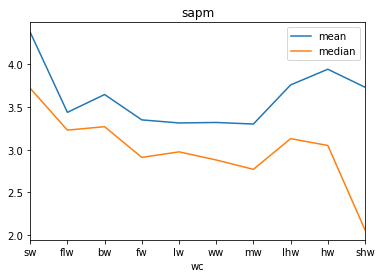


slpm
         mean       std  median     iqr
wc                                     
sw   3.623913  1.574501   3.610  2.3000
flw  3.116667  1.388965   3.175  1.8300
bw   3.030366  1.895586   2.720  1.9400
fw   2.825903  1.634019   2.645  1.9825
lw   2.556806  1.559492   2.350  2.0200
ww   2.558552  1.514921   2.455  1.9675
mw   2.428832  1.500536   2.210  1.8650
lhw  2.469786  1.766997   2.250  2.3000
hw   2.421449  1.898670   2.185  2.2850
shw  2.163182  1.721946   1.955  2.0425


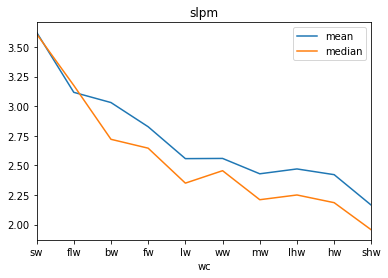


str_acc
         mean       std  median    iqr
wc                                    
sw   0.431449  0.124632   0.430  0.130
flw  0.411597  0.102961   0.415  0.120
bw   0.401502  0.120032   0.400  0.150
fw   0.410764  0.118845   0.410  0.130
lw   0.397153  0.140109   0.400  0.140
ww   0.410860  0.142113   0.420  0.140
mw   0.422564  0.156358   0.430  0.160
lhw  0.423096  0.163211   0.430  0.170
hw   0.418986  0.186469   0.430  0.170
shw  0.435455  0.165895   0.425  0.225


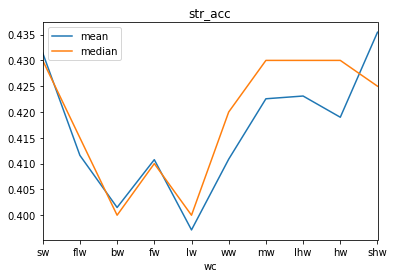


str_def
         mean       std  median     iqr
wc                                     
sw   0.538986  0.132111   0.550  0.1100
flw  0.558472  0.117314   0.570  0.1400
bw   0.551282  0.110611   0.570  0.1500
fw   0.551493  0.119774   0.560  0.1325
lw   0.540602  0.128443   0.560  0.1500
ww   0.517964  0.125519   0.535  0.1500
mw   0.497892  0.144151   0.520  0.1500
lhw  0.493950  0.140338   0.510  0.1700
hw   0.466703  0.153766   0.480  0.1900
shw  0.443636  0.163955   0.420  0.1775


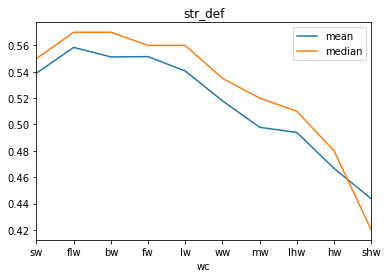


td_acc
         mean       std  median     iqr
wc                                     
sw   0.328406  0.299807   0.300  0.5000
flw  0.319931  0.273390   0.305  0.4775
bw   0.313846  0.287367   0.300  0.5000
fw   0.292812  0.268361   0.280  0.4700
lw   0.327037  0.285004   0.330  0.5000
ww   0.353507  0.299633   0.340  0.5000
mw   0.333618  0.307882   0.330  0.5000
lhw  0.278114  0.281272   0.250  0.4800
hw   0.296413  0.331743   0.235  0.5000
shw  0.421364  0.406217   0.375  0.7500


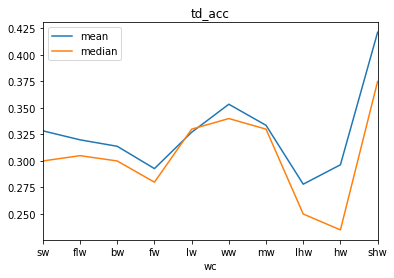


td_avg
         mean       std  median     iqr
wc                                     
sw   1.247101  1.457343   0.770  1.7800
flw  1.373819  1.439664   1.000  1.9775
bw   1.395421  1.570843   0.950  2.2000
fw   1.463368  1.770440   0.930  2.2275
lw   1.599560  1.920057   1.200  2.4350
ww   1.486267  1.653230   1.055  2.2275
mw   1.572564  2.201712   1.040  2.2300
lhw  1.393701  2.134180   0.680  2.0000
hw   1.306957  2.574317   0.490  1.8400
shw  1.357273  1.677036   0.625  2.3800


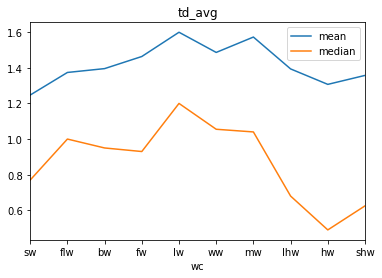


td_def
         mean       std  median     iqr
wc                                     
sw   0.519710  0.317231    0.53  0.4200
flw  0.508194  0.304857    0.55  0.3925
bw   0.502454  0.315822    0.52  0.4700
fw   0.514861  0.329354    0.56  0.4900
lw   0.457894  0.313402    0.50  0.5000
ww   0.468937  0.311431    0.50  0.4300
mw   0.446296  0.328912    0.50  0.6600
lhw  0.394947  0.341947    0.42  0.6600
hw   0.394275  0.350356    0.38  0.6925
shw  0.355909  0.405376    0.08  0.7050


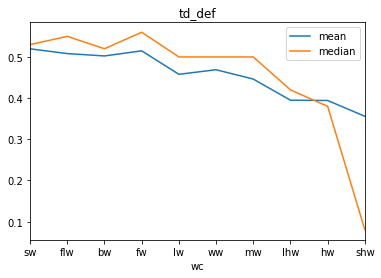


eff
         mean       std    median       iqr
wc                                         
sw   1.109629  1.130182  0.824882  0.551832
flw  1.021176  0.561554  0.909091  0.645804
bw   0.987829  0.719389  0.886977  0.610328
fw   1.009657  0.737149  0.876000  0.604757
lw   0.939575  0.827699  0.802139  0.643615
ww   0.966077  0.847014  0.838739  0.687521
mw   1.035421  1.234018  0.829940  0.679863
lhw  1.191797  4.732203  0.777778  0.774723
hw   0.993341  1.404202  0.685506  0.812501
shw  0.837638  0.718996  0.578704  0.831723


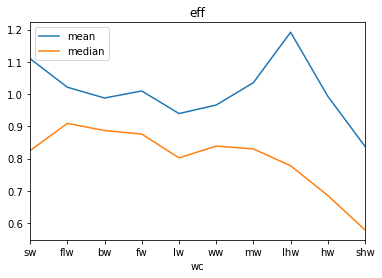


active
         mean       std  median     iqr
wc                                     
sw   8.001159  3.892700   7.580  3.2500
flw  6.555000  2.286540   6.275  2.9000
bw   6.677546  3.223588   6.140  3.1800
fw   6.175937  3.059798   5.755  3.4950
lw   5.870579  2.861698   5.530  3.2825
ww   5.878077  2.930390   5.460  3.2475
mw   5.730057  3.181094   5.230  2.7200
lhw  6.229395  4.203780   5.770  3.3800
hw   6.365145  4.527566   5.630  3.4125
shw  5.895909  6.192418   4.195  3.7600


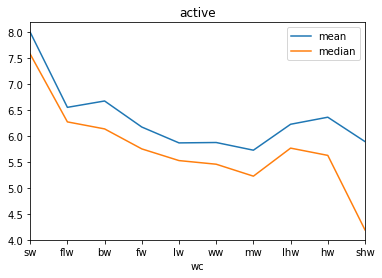


grind
         mean       std    median       iqr
wc                                         
sw   2.426451  2.433284  1.333333  1.783333
flw  2.939525  4.703540  1.511905  2.493074
bw   3.034147  4.884320  1.568750  2.618495
fw   2.450246  2.960728  1.421429  2.763333
lw   2.659597  3.781548  1.556250  2.749692
ww   2.538128  4.045827  1.490000  2.276429
mw   1.989369  2.297377  1.323158  2.219391
lhw  3.010943  5.803339  1.471429  2.733586
hw   2.336208  3.473996  1.133704  2.103463
shw  2.004846  2.469228  1.273214  1.555746


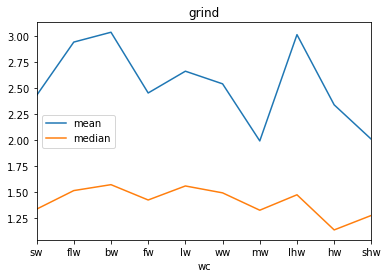


st_ratio
          mean         std     median        iqr
wc                                              
sw   76.221005  103.355655  34.803922  62.109844
flw  48.034093   71.215431  30.236842  40.338878
bw   45.309328   54.052968  28.333333  45.487380
fw   42.431855   49.295300  22.513345  41.677544
lw   38.805022   64.274290  19.439462  31.356477
ww   38.331882   49.972786  22.416996  32.859831
mw   37.643969   52.796400  21.737968  33.159859
lhw  40.704441   60.048955  19.771266  34.333084
hw   39.955538   62.663578  21.951396  35.736091
shw  24.358335   27.536184  12.843331  28.559213


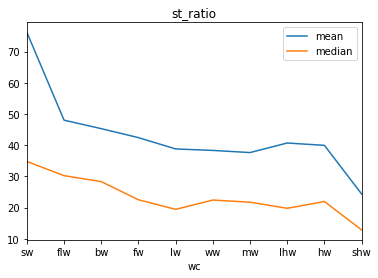


age
          mean       std     median        iqr
wc                                            
sw   31.650875  4.722697  31.550685   6.246575
flw  31.214605  4.434205  31.416438   6.021918
bw   32.776641  4.933225  32.545205   7.326027
fw   33.368678  5.045112  32.835616   6.884932
lw   35.547684  5.167777  35.306849   7.349315
ww   36.195118  5.610176  36.073973   7.432877
mw   37.417191  6.281343  37.361644   9.016438
lhw  39.015039  7.341270  38.989041  10.945205
hw   40.063037  7.095048  40.372603   9.761644
shw  48.642682  4.741274  49.265753   6.831507


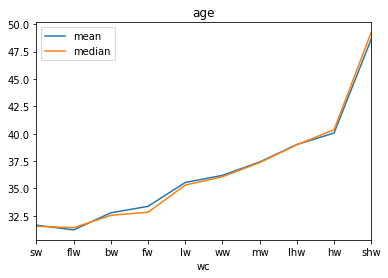


ape_ratio
         mean       std    median       iqr
wc                                         
sw   1.010300  0.026152  1.015625  0.045587
flw  1.013318  0.025266  1.014706  0.030303
bw   1.019689  0.030490  1.015152  0.043478
fw   1.021887  0.026851  1.014925  0.043478
lw   1.023866  0.027733  1.026667  0.043478
ww   1.027844  0.024053  1.028169  0.028817
mw   1.029104  0.029292  1.027778  0.036631
lhw  1.028752  0.027081  1.027027  0.029524
hw   1.031866  0.025736  1.027397  0.038615
shw       NaN       NaN       NaN       NaN


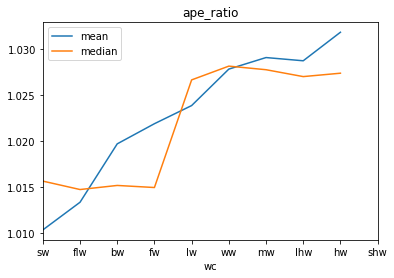

In [538]:
for stat in stats+attr:
    print(f'\n{stat}')
    print(gb[stat])
    
    # Plot
    gb[stat]['mean'].plot(label='mean')
    gb[stat]['median'].plot(label='median')
    plt.title(stat)
    plt.legend()
    plt.show()

In [539]:
for col in stats+attr:
    df[f'z_{col}'] = wc_normalize(df, col, gb, False)

In [540]:
df.dropna(subset=['age']).sort_values('age')[['name1', 'age']].ends(10)

In [541]:
df.columns

Index(['d', 'l', 'nc', 'w', 'association', 'country', 'dob', 'fname',
       'height1', 'height2', 'lname', 'locality', 'name1', 'nick1', 'reach',
       'sapm', 'slpm', 'stance', 'str_acc', 'str_def', 'sub_avg', 'td_acc',
       'td_avg', 'td_def', 'weight1', 'eff', 'active', 'grind', 'ape_ratio',
       'st_ratio', 'age', 'wc', 'w_pct', 'z_sapm', 'z_slpm', 'z_str_acc',
       'z_str_def', 'z_td_acc', 'z_td_avg', 'z_td_def', 'z_eff', 'z_active',
       'z_grind', 'z_st_ratio', 'z_age', 'z_ape_ratio'],
      dtype='object')

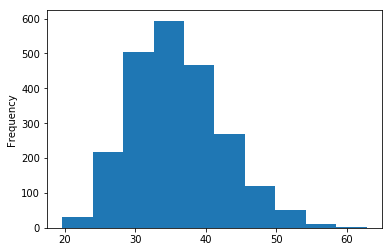

In [542]:
df.age.plot.hist()
plt.show()

In [543]:
df.loc[df.age > 40, ['name1', 'age']]\
  .sort_values('age', ascending=False).head(20)

,name1,age
1585,Yoshiaki Yatsu,62.797260
11,Maurice Smith,57.391781
1310,Herschel Walker,57.172603
2538,Nobuhiko Takada,57.063014
929,Randy Couture,55.868493
1635,Paulo Cesar Silva,55.789041
2188,Tadao Yasuda,55.569863
14,Ken Shamrock,55.227397
1787,Jose Canseco,54.838356
167,Mark Coleman,54.369863


In [544]:
for stat in stats:
    print('\n' + stat + '\n')
    print(top_cats(df, 'country', val=10).groupby('country')[stat]\
          .mean()\
          .sort_values(ascending=False))


sapm

country
Australia    4.053810
Sweden       3.626923
Poland       3.486471
Canada       3.356667
USA          3.282816
England      3.270000
Japan        3.263469
Brazil       3.178954
Mexico       3.094000
Russia       2.616522
France       2.531000
Name: sapm, dtype: float64

slpm

country
Poland       3.084706
Canada       2.752576
Mexico       2.737333
Australia    2.654762
Brazil       2.620261
USA          2.606579
Russia       2.561304
France       2.525000
Sweden       2.520769
England      2.504909
Japan        1.856531
Name: slpm, dtype: float64

str_acc

country
Sweden       0.466923
Poland       0.461765
Australia    0.458095
France       0.444000
Canada       0.434545
Russia       0.426957
Brazil       0.418039
USA          0.410408
England      0.397818
Japan        0.393469
Mexico       0.364667
Name: str_acc, dtype: float64

str_def

country
Mexico       0.578667
Russia       0.574783
Brazil       0.544444
Canada       0.528939
USA          0.528053
England      0

In [545]:
df[['name1', 'st_ratio']].sort_values('st_ratio', ascending=False).ends(10)

In [546]:
df.loc[df.lname.isin(['Gaethje', 'Holloway', 'Dillashaw', 'Nurmagomedov']), 
       stats+['name1']]

,sapm,slpm,str_acc,str_def,td_acc,td_avg,td_def,eff,active,grind,st_ratio,name1
968,1.70,4.29,0.49,0.66,0.44,5.09,0.84,2.523529,5.99,8.483333,12.642436,Khabib Nurmagomedov
1240,4.03,6.90,0.46,0.64,0.83,0.32,0.83,1.712159,10.93,0.640000,323.437500,Max Holloway
1393,10.23,8.50,0.54,0.53,0.00,0.00,0.80,0.830890,18.73,NaN,NaN,Justin Gaethje
1595,1.95,4.69,0.59,0.64,0.09,0.86,1.00,2.405128,6.64,NaN,81.802326,Said Nurmagomedov
2156,1.02,1.63,0.50,0.79,0.00,0.00,0.00,1.598039,2.65,NaN,NaN,Jeremie Holloway
2249,3.07,0.70,0.42,0.34,0.35,3.00,0.16,0.228013,3.77,3.000000,3.500000,Gabrielle Holloway
2532,3.03,5.37,0.41,0.65,0.37,1.68,0.86,1.772277,8.40,1.680000,47.946429,TJ Dillashaw


In [547]:
df[['name1', 'active']].sort_values('active', ascending=False).head()

,name1,active
1559,Tebaris Gordon,52.94
1660,Dashawn Boatwright,52.50
2466,Antonio Jones,37.50
2001,Sean O'Haire,31.04
2551,Maiara Amanajas dos Santos,30.00


In [548]:
top_cats(df, 'association', val=10).groupby('association')['sapm'].mean()

association
Alliance MMA                   3.070625
American Kickboxing Academy    2.842353
American Top Team              3.301346
Blackzilians                   2.962778
Grudge Training Center         3.257692
Jackson-Wink MMA               3.027436
MMA Lab                        3.483571
Nova Uniao                     3.293889
Renzo Gracie Jiu-Jitsu         2.673000
Team Nogueira                  3.045000
Tristar Gym                    2.758125
Xtreme Couture                 2.648000
Name: sapm, dtype: float64

In [549]:
for stat in stats:
    print(f'\n{stat}\n')
    print(top_cats(df, 'association', val=10).groupby('association')
          [stat].mean().sort_values())


sapm

association
Xtreme Couture                 2.648000
Renzo Gracie Jiu-Jitsu         2.673000
Tristar Gym                    2.758125
American Kickboxing Academy    2.842353
Blackzilians                   2.962778
Jackson-Wink MMA               3.027436
Team Nogueira                  3.045000
Alliance MMA                   3.070625
Grudge Training Center         3.257692
Nova Uniao                     3.293889
American Top Team              3.301346
MMA Lab                        3.483571
Name: sapm, dtype: float64

slpm

association
Renzo Gracie Jiu-Jitsu         2.207000
Team Nogueira                  2.375000
Nova Uniao                     2.878889
Xtreme Couture                 2.966000
Jackson-Wink MMA               2.975385
Alliance MMA                   2.986875
American Top Team              3.095769
Grudge Training Center         3.146154
Tristar Gym                    3.171250
Blackzilians                   3.177222
MMA Lab                        3.222857
American Kickbo

In [550]:
df.wc.value_counts(dropna=False)

ww     442
lw     432
mw     351
fw     288
lhw    281
hw     276
bw     273
flw    144
sw      69
shw     22
NaN     11
Name: wc, dtype: int64

In [566]:
df.shape

(2589, 47)

In [567]:
df.to_csv('data/final.csv', index=False)